# DCGAN (Deep Convolutional GAN)

## ✅ 개요
- DCGAN은 GAN(Generative Adversarial Network)의 한 종류로,
- Generator와 Discriminator 모두에 **합성곱 신경망(CNN)** 구조를 사용한 생성 모델
- 이미지를 생성하는 데 최적화된 GAN 구조로, 특히 **이미지 생성, 변환, 복원** 등에서 활용

---

## 🔧 구성

### 1. Generator (G)
- **입력**: 랜덤 노이즈 벡터 `z` (예: 100차원)
- **역할**: 가짜 이미지를 생성하여 Discriminator를 속이는 것
- **구조**: ConvTranspose2d, BatchNorm2d, ReLU, Tanh 등 사용

### 2. Discriminator (D)
- **입력**: 진짜 이미지 또는 G가 만든 가짜 이미지
- **역할**: 이미지가 진짜인지 가짜인지 식별
- **구조**: Conv2d, BatchNorm2d, LeakyReLU, Sigmoid 등 사용

---

## 🧠 학습 과정

1. **G**는 `z`로부터 가짜 이미지 생성: `fake = G(z)`
2. **D**는 진짜 이미지와 가짜 이미지를 구분하려 함
3. **D**는 진짜는 1, 가짜는 0에 가깝게 출력하도록 학습
4. **G**는 D를 속이기 위해 D가 `G(z)`를 1이라고 믿게 하도록 학습

---

## 📉 손실 함수 (Binary Cross Entropy)
$$\mathcal{L}_{BCE} = -[y \log(p) + (1 - y) \log(1 - p)]$$

- Generator loss:
    - 생성한 이미지의 판별은 1로 학습
    - 이진 크로스 엔트로피 (y=1이고 p=D(G(z)))
$$
\mathcal{L}_G = -\log(D(G(z)))
$$


- Discriminator loss:
  - 실제 이미지 x는 1로, 생성한 이미지는 0으로 판별하는 학습
  - 이진 크로스 엔트로피 (y=1이고 p=D(x) + y=0이고 p=D(G(z)))
  - 실제 코드에서는 두 개의 BCE를 써서 2로 나눠 평균을 냄.
$$
\mathcal{L}_D = -\log(D(x)) - \log(1 - D(G(z)))
$$

---

## ✅ 특징

- CNN 구조 사용 (MLP가 아닌 Conv)
- Fully Connected Layer 없음
- Pooling 대신 Strided Convolution 사용
- Batch Normalization 적극 활용
- Generator에는 마지막 활성화 함수로 `Tanh()` 사용 (출력값 [-1, 1])

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            # z는 (100)인 1차원 이지만, 연산 시 (100,1,1)로 3차원으로 계산
            # (in_channel, out_channel, kernel, stride, padding)
            # 업샘플링 작업
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0),  # 7x7
            # 각 채널별 배치정규화 (미니배치 × H × W)
            nn.BatchNorm2d(128),
            # True=레이어별 새 변수 안만들고 덮어쓰겠다는 뜻
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1),       # 28x28
            nn.Tanh() # 기존 분포 형태 유지
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))

## ConvTranspose2d 연산 시각화

ConvTranspose2d가 어떻게 입력을 확장하여 출력 이미지를 생성하는지 보여주는 시각화

![Transposed Conv2D 시각화](./transposedConv2d.png)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # 14x14
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),  # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            # 참, 거짓 판별
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [20]:
# ----- 하이퍼파라미터 -----
z_dim = 100
batch_size = 128
epochs = 10
lr = 0.0002
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("사용 중인 디바이스:", device)

사용 중인 디바이스: mps


In [21]:
# ----- 데이터 로딩 -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNIST를 [-1, 1] 범위로 정규화
])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [22]:
# ----- 모델 초기화 -----
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [23]:
# ----- 손실 함수 & 옵티마이저 -----
criterion = nn.BCELoss() # 이진 크로스 엔트로피
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# betas=(0.5, 0.999): Adam에서 사용하는 1차/2차 모멘텀 하이퍼파라미터

In [24]:
# ----- 학습 루프 -----
for epoch in range(epochs):
    d_loss = torch.tensor(0.0)
    g_loss = torch.tensor(0.0)
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0) # size가 (128, 1, 28, 28) 이면 128을 가져옴 (0번째)

        # 진짜/가짜 레이블
        real_labels = torch.ones(batch_size, 1).to(device) # 정답이니까 1, 배치 크기 만큼 출력되므로..
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ----- Discriminator 학습 -----
        z = torch.randn(batch_size, z_dim).to(device) # 랜덤한 노이즈
        fake_imgs = G(z) # G network에 담아 새로 생성

        real_loss = criterion(D(real_imgs), real_labels) # 실제 이미지는 1로 구별하게 학습
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels) # 생성한 이미지는 0으로 구별하게 학습
        # detach()는 자동 미분되지 않게 해주는 것. 왜? fake_imgs만들 때 G를 사용헀는데 이거는 생성하기 위한 거고 학습하면 안되서,
        # 그 G(z)가 학습되지 않도록 자동 미분을 끊어 주는 것.
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ----- Generator 학습 -----
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)
        g_loss = criterion(D(fake_imgs), real_labels)  # 생성된 이미지가 진짜로 분류하게 학습

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"[{epoch+1}/{epochs}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

[1/10] D_loss: 0.2560, G_loss: 1.8035
[2/10] D_loss: 0.2463, G_loss: 1.6984
[3/10] D_loss: 0.3238, G_loss: 2.1562
[4/10] D_loss: 0.3289, G_loss: 2.7613
[5/10] D_loss: 0.3708, G_loss: 0.5387
[6/10] D_loss: 0.2930, G_loss: 2.3119
[7/10] D_loss: 0.3173, G_loss: 1.4156
[8/10] D_loss: 0.2643, G_loss: 1.6829
[9/10] D_loss: 0.4191, G_loss: 1.8709
[10/10] D_loss: 0.3473, G_loss: 2.1934


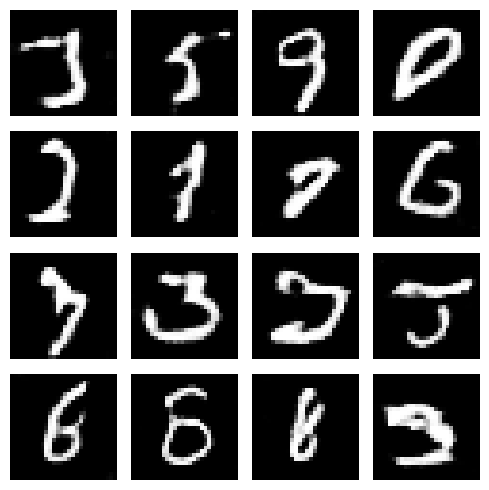

In [27]:
# ----- 결과 시각화 -----
def show_generated_images(generator, num_images=16):
    generator.eval()
    z = torch.randn(num_images, z_dim).to(device)
    fake_imgs = generator(z).detach().cpu()

    fake_imgs = fake_imgs * 0.5 + 0.5  # [-1,1] -> [0,1]
    grid_size = int(num_images ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

    for i in range(grid_size):
        for j in range(grid_size):
            axes[i, j].imshow(fake_imgs[i * grid_size + j][0], cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_generated_images(G)